# ltu-ili lampe backend
This is a tutorial for using the lampe backend with custom embedding networks. Here, we use a graph-based embedding and a custom dataloader.

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch_geometric as pyg

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


## QM7b Graph Dataset
This tutorial uses the MoleculeNet QM7b benchmarking dataset (https://arxiv.org/abs/1703.00564). The data is the molecular structure of various compounds, and the task is to infer various chemical properties.

In [2]:
# Using the QM7b dataset from pytorch geometric
# Ref: https://arxiv.org/abs/1703.00564

data = pyg.datasets.QM7b(root='./toy')  # download the dataset
x = data  # graph inputs
theta = data.y  # parameters

# Let's only look at the first 5 parameters
dim_theta = 5
theta = theta[:,:dim_theta]

tensor([-1.2540e+03,  6.7292e+00,  3.3204e-01, -9.4720e+00,  2.1900e-01])


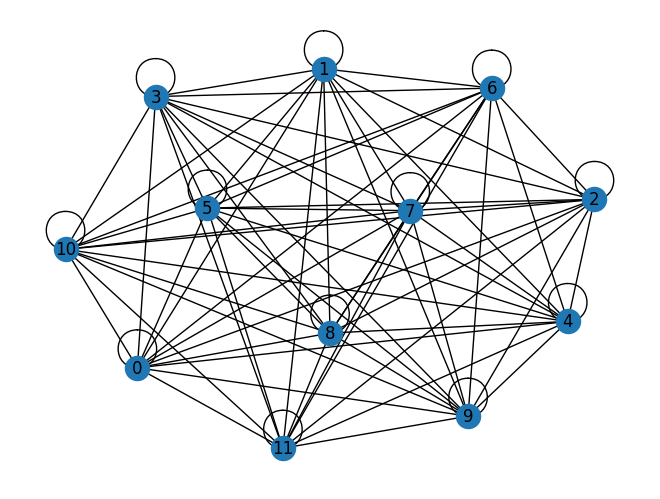

In [3]:
import networkx as nx

# plot an example molecule
i = np.random.randint(len(data))
x_, y_ = x[i], theta[i]
g = pyg.utils.to_networkx(x_, to_undirected=True)
nx.draw(g, with_labels=True)
print(y_)

In [4]:
# Create custom dataloaders using the torch_geometric collater

from torch.utils.data import DataLoader
from ili.dataloaders import TorchLoader
from torch_geometric.loader.dataloader import Collater

# use pyg's collater
collater = Collater(data)

# output (input, output) pairs
def collate_fn(batch):
    batch = collater(batch)
    return batch, batch.y[:,:dim_theta]

# train/val split
mask = np.random.rand(len(data)) < 0.9
train_data = data[mask]
val_data = data[~mask]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

# define an ili loader
loader = TorchLoader(train_loader, val_loader)
    

In [5]:
# Design a custom Graph Attention Network embedder

import torch
from torch_geometric import nn as gnn
from torch_geometric.nn import aggr
from torch import nn
import torch.nn.functional as F

class GATNetwork(nn.Module):
    def __init__(
        self, in_channels, gcn_channels, gcn_heads,
        dense_channels, out_channels, drop_p=0.1,
        edge_dim=None
    ):
        super().__init__()
        self.in_channels = in_channels
        self.dense_channels = dense_channels
        self.out_channels = out_channels
        self.drop_p = drop_p
        self.edge_dim = edge_dim
        self.gcn_channels = gcn_channels
        self.gcn_heads = gcn_heads

        self.graph_aggr = aggr.MultiAggregation(
            aggrs=['sum', 'mean', 'std', 'min',
                   'max', aggr.SoftmaxAggregation(learn=True)],
            mode='cat'
        )
        self.dropout = torch.nn.Dropout(p=self.drop_p)

        self._build_gnn()
        self._build_dnn(gcn_channels[-1]*len(self.graph_aggr.aggrs))
        
    def _build_dnn(self, in_channels):
        self.fc1 = torch.nn.Linear(in_channels, self.dense_channels[0])
        self.fcs = torch.nn.ModuleList(
            [torch.nn.Linear(self.dense_channels[i], self.dense_channels[i+1])
             for i in range(0, len(self.dense_channels)-1)])
        self.fc2 = torch.nn.Linear(self.dense_channels[-1], self.out_channels)

    def dnn(self, x):
        x = F.relu(self.fc1(x))
        for fc in self.fcs:
            x = self.dropout(x)
            x = F.relu(fc(x))
        x = self.fc2(x)
        return x
    
    def _build_gnn(self):
        self.conv1 = gnn.GATv2Conv(
            self.in_channels, self.gcn_channels[0], 
            heads=self.gcn_heads[0], edge_dim=self.edge_dim)
        self.convs = torch.nn.ModuleList(
            [gnn.GATv2Conv(self.gcn_channels[i]*self.gcn_heads[i],
                           self.gcn_channels[i+1], heads=self.gcn_heads[i+1],
                           edge_dim=self.edge_dim)
             for i in range(len(self.gcn_channels)-2)]
        )
        self.conv2 = gnn.GATv2Conv(
            self.gcn_channels[-2]*self.gcn_heads[-2],
            self.gcn_channels[-1], heads=self.gcn_heads[-1], 
            concat=False, edge_dim=self.edge_dim)

    def gnn(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        return x

    def forward(self, x):
        node_features = torch.ones(x.num_nodes, 1).to(x.y.device)
        edge_index, edge_attr = x.edge_index, x.edge_attr
        ptr = x.ptr if hasattr(x, 'ptr') else None

        x = self.gnn(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        x = self.graph_aggr(x, ptr=ptr)
        x = self.dnn(x)
        return x
    
embedding = GATNetwork(
    in_channels=1, gcn_channels=[4, 8], 
    gcn_heads=[4, 4],
    dense_channels=[32, 16], out_channels=6,
    edge_dim=1
)

In [6]:
# define a prior
prior = ili.utils.IndependentNormal(loc=[0]*dim_theta, scale=[1]*dim_theta, 
                                    device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, 
                             embedding_net=embedding, x_normalize=False, device=device),
    ili.utils.load_nde_lampe(model='mdn', hidden_features=50, num_components=6, 
                             embedding_net=embedding, x_normalize=False, device=device)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 2e-5,
    'stop_after_epochs': 30
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [7]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
88 epochs [05:23,  3.68s/ epochs, loss=9.48, loss_val=10.4]
INFO:root:Training model 2 / 2.
210 epochs [10:15,  2.93s/ epochs, loss=8.62, loss_val=9.55]
INFO:root:It took 940.4324412345886 seconds to train models.


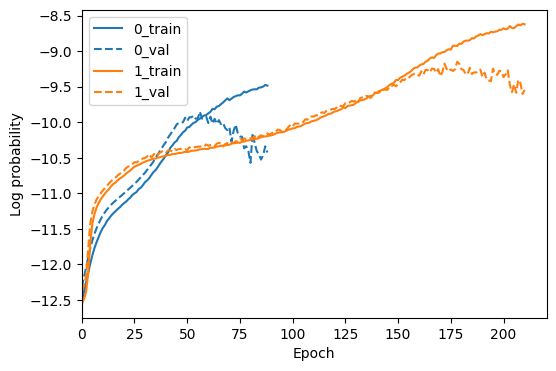

In [8]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [9]:
# Now, LampeRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = None
np.random.seed(seed_in)
ind = np.random.randint(len(data))
x_ = data[ind]
y_ = data.y[ind, :dim_theta]

# generate samples from the posterior using accept/reject sampling
seed_samp = 1234
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), data[ind])

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, data[ind])

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

INFO:root:Sampling models with tensor([331., 669.], device='cuda:0') samples each.


['', '']


Drawing 669 posterior samples: 100%|██████████| 669/669 [00:00<00:00, 15756.99it/s]


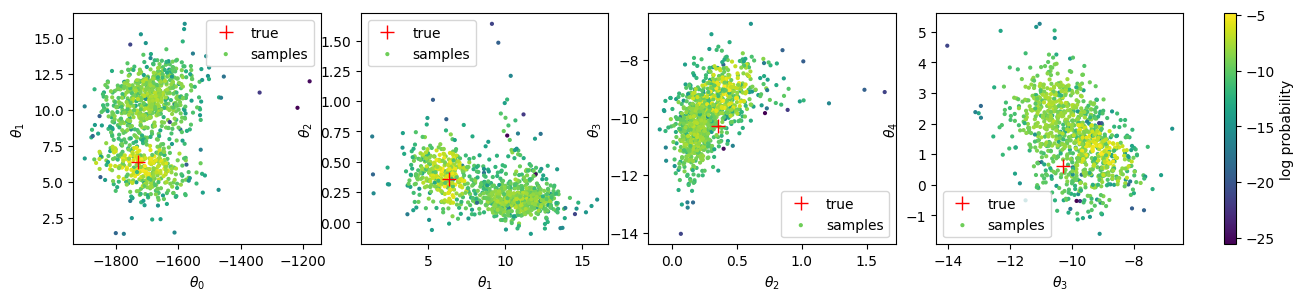

In [10]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, dim_theta, figsize=(3*dim_theta,3), 
                        gridspec_kw={'width_ratios': [1]*(dim_theta-1)+[0.05]})
for i in range(dim_theta-1):
    axs[i].plot(y_[i], y_[i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, 
                        label='samples')
    # axs[i].set_aspect('equal')
    # axs[i].set_xlim(-3,3)
    # axs[i].set_ylim(-3,3)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[-1])

INFO:root:Sampling models with tensor([331., 669.], device='cuda:0') samples each.
Drawing 669 posterior samples: 100%|██████████| 669/669 [00:00<00:00, 131127.13it/s]


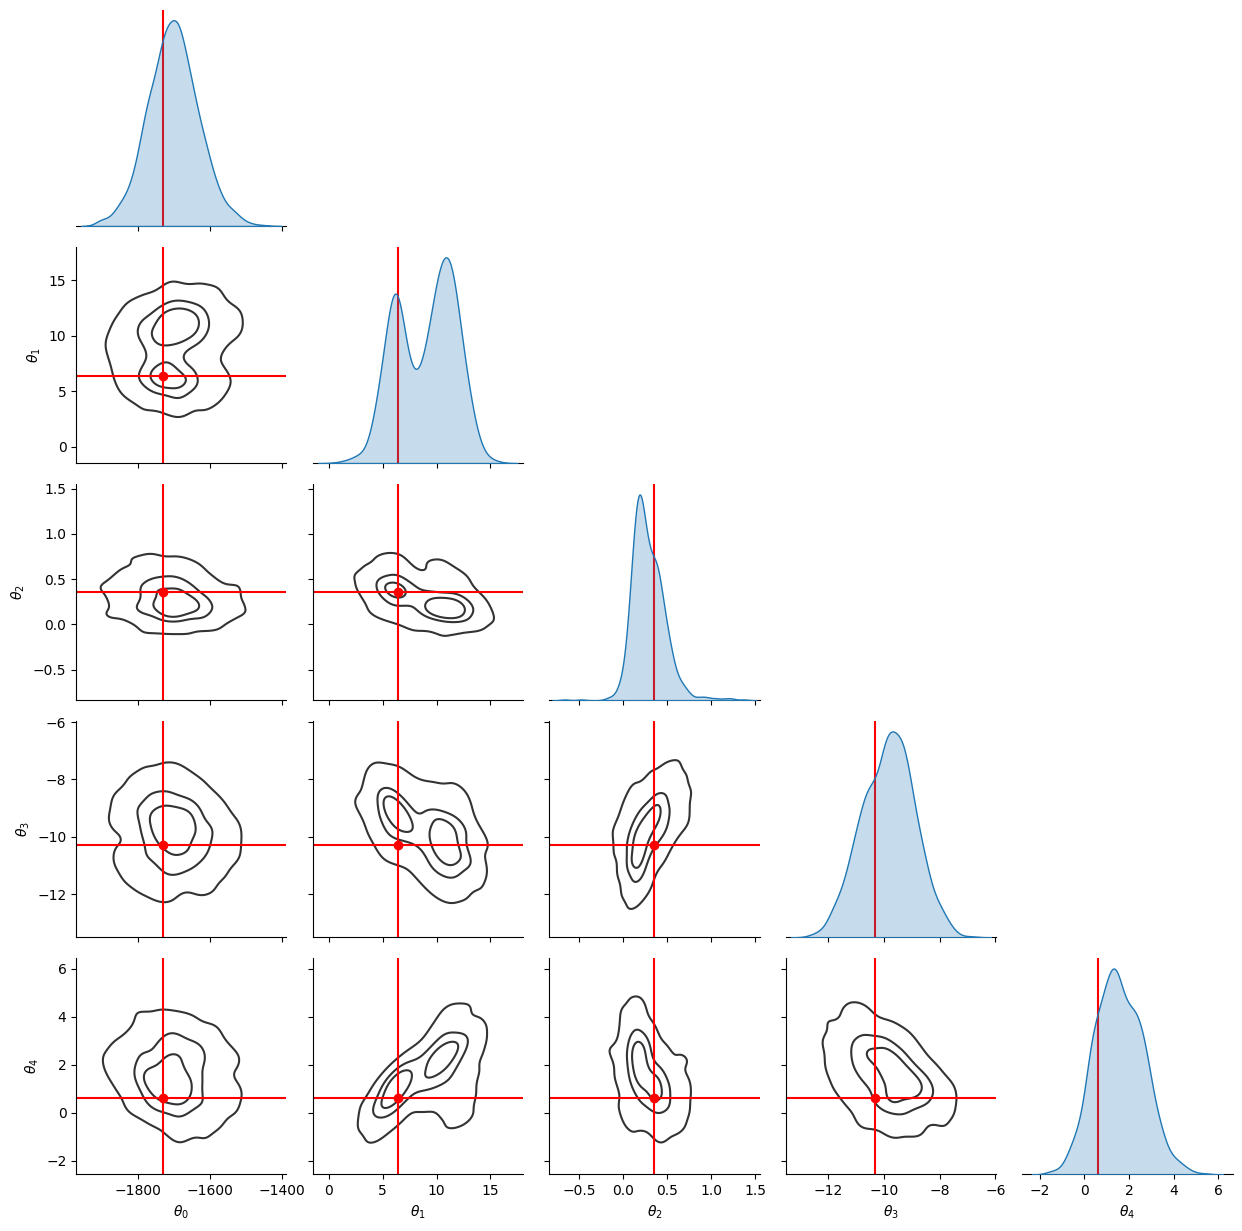

In [11]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_, theta_fid=y_
)

In [12]:
x = loader.get_all_data()
y = loader.get_all_parameters()

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


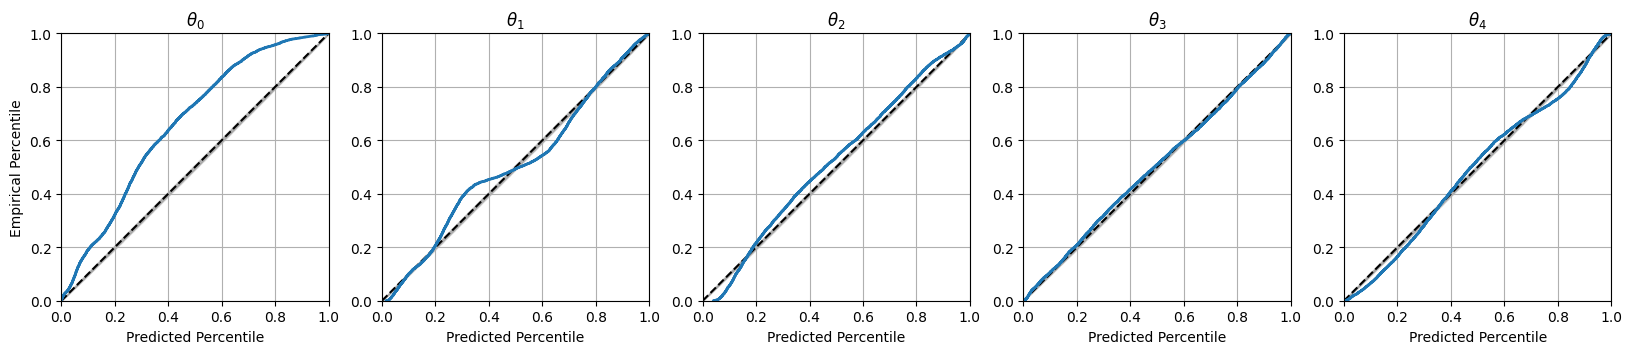

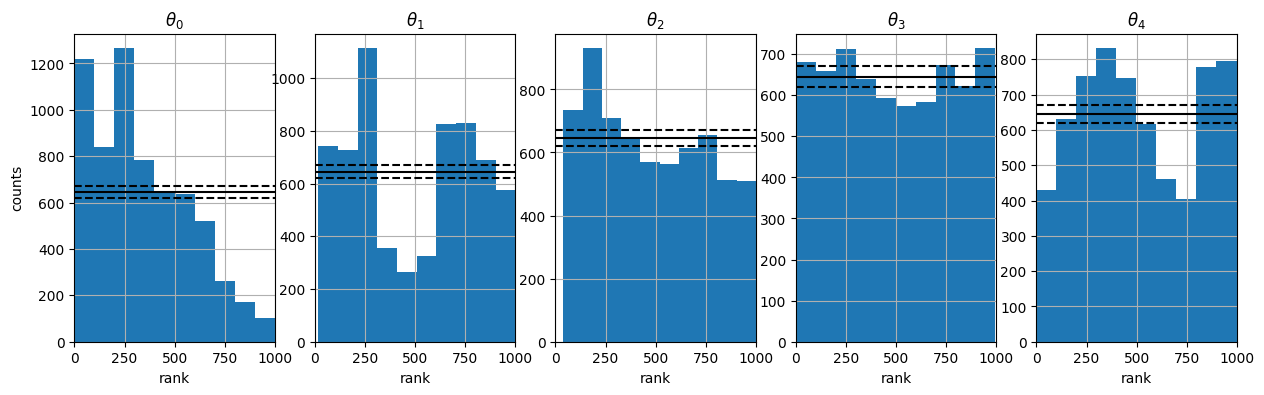

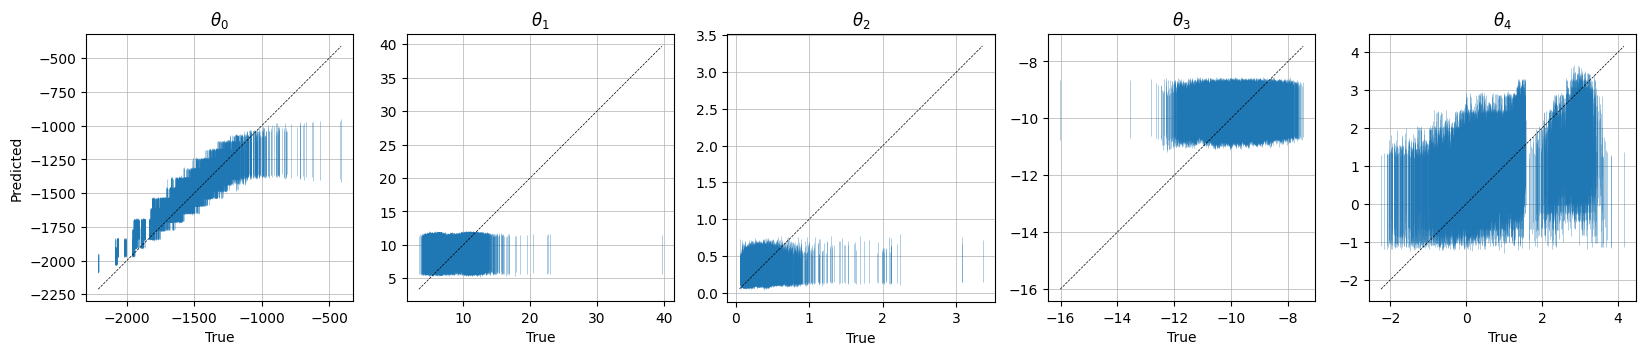

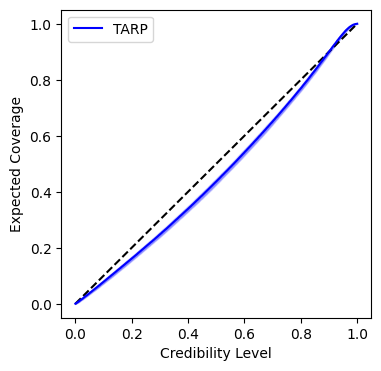

In [13]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble,
    x=x, theta=y[:, :dim_theta]
)